   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  
Train size: 16512, Test size: 4128


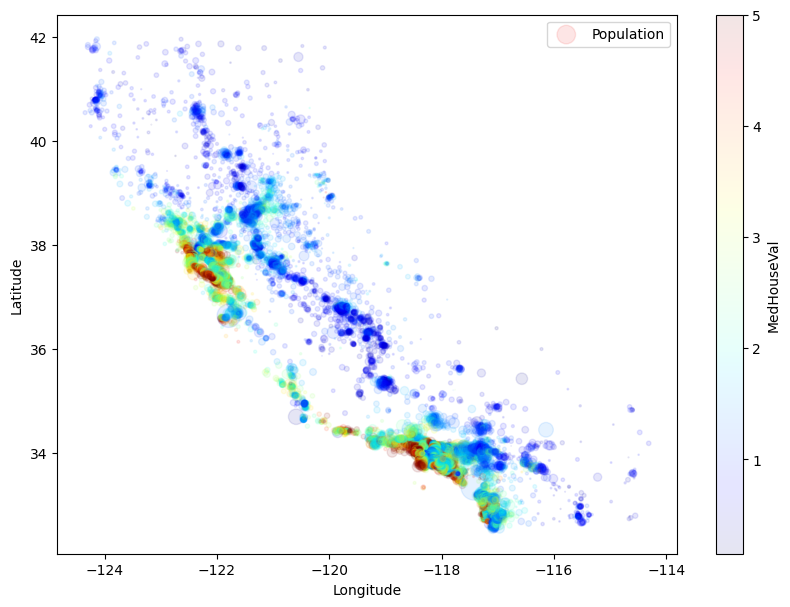

MedHouseVal    1.000000
MedInc         0.688075
AveRooms       0.151948
HouseAge       0.105623
AveOccup      -0.023737
Population    -0.024650
Longitude     -0.045967
AveBedrms     -0.046701
Latitude      -0.144160
Name: MedHouseVal, dtype: float64
Training RMSE: 0.715799153944732
Cross-validated RMSE: 0.7351230938666955
Best params: {'max_features': 8, 'n_estimators': 30}
Final RMSE on Test Set: 0.19306693387185672


['housing_model.pkl']

In [13]:
# Ch 2: End-to-End Machine Learning Project 

# 1. Load and Inspect the Data
from sklearn.datasets import fetch_california_housing
import pandas as pd

housing = fetch_california_housing(as_frame=True)
df = housing.frame
print(df.head())

# 2. Train-Test Split
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train size: {len(train_set)}, Test size: {len(test_set)}")

# 3. Visualize the Data
import matplotlib.pyplot as plt

df.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.1,
        s=df["Population"]/100, label="Population", figsize=(10, 7),
        c="MedHouseVal", cmap="jet", colorbar=True)
plt.legend()
plt.show()

# 4. Correlation Matrix
corr_matrix = df.corr(numeric_only=True)
print(corr_matrix["MedHouseVal"].sort_values(ascending=False))

# 5. Feature Engineering
def add_extra_features(df):
    df = df.copy()  # avoid modifying original
    df["rooms_per_household"] = df["AveRooms"] / (df["Population"] / df["AveOccup"])
    df["bedrooms_per_room"] = df["AveBedrms"] / df["AveRooms"]
    return df

# Transformer to add extra features
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):  # no hyperparameters yet
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        rooms_per_household = X["AveRooms"] / (X["Population"] / X["AveOccup"])
        bedrooms_per_room = X["AveBedrms"] / X["AveRooms"]
        X["rooms_per_household"] = rooms_per_household
        X["bedrooms_per_room"] = bedrooms_per_room
        return X

# 6. Data Preparation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X = df.drop("MedHouseVal", axis=1)
y = df["MedHouseVal"]
X_prepared = num_pipeline.fit_transform(X)

num_pipeline = Pipeline([
    ('attribs_adder', CombinedAttributesAdder()),
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler()),
])

X_prepared = num_pipeline.fit_transform(X)

# 7. Train a Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

lin_reg = LinearRegression()
lin_reg.fit(X_prepared, y)

predictions = lin_reg.predict(X_prepared)
rmse = np.sqrt(mean_squared_error(y, predictions))
print(f"Training RMSE: {rmse}")

# 8. Cross-Validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg, X_prepared, y,
                         scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-scores)
print(f"Cross-validated RMSE: {rmse_scores.mean()}")

# 9. Grid Search with Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"n_estimators": [10, 30], "max_features": [4, 6, 8]},
]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring="neg_mean_squared_error")
grid_search.fit(X_prepared, y)
print("Best params:", grid_search.best_params_)

# 10. Ensemble Model
from sklearn.ensemble import VotingRegressor

ensemble_model = VotingRegressor(estimators=[
    ('lr', lin_reg),
    ('rf', grid_search.best_estimator_),
])
ensemble_model.fit(X_prepared, y)

# 11. Final Evaluation on Test Set
X_test = test_set.drop("MedHouseVal", axis=1)
X_test = add_extra_features(X_test)
y_test = test_set["MedHouseVal"]
X_test_prepared = num_pipeline.transform(X_test)

final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test_prepared)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
print(f"Final RMSE on Test Set: {final_rmse}")

# 12. Save the Model
import joblib
joblib.dump(final_model, "housing_model.pkl")